In [1]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import os
from torchvision.utils import make_grid
import numpy as np

from config import config, arch
from dataloader import get_dataloader
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN

def load_model():
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN':RGB_SFMCNN}
    checkpoint_filename = 'RGB_SFMCNN_best_weight'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth' , weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size = (config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)
    return model

def load_dataloader():
    return get_dataloader(dataset='HeartCalcification', root=config['root'] + '/data/',
                          batch_size=config['batch_size'], input_size=config['input_shape'])

def predict(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(pred_labels, true_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def visualize_image(img, label, save_path=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    height, width = img.shape[:2]
    num_blocks_h, num_blocks_w = label.shape

    # 繪製網格線
    for i in range(1, num_blocks_h):
        plt.axhline(y=i * height / num_blocks_h, color='w', linestyle='-', linewidth=1)
    for j in range(1, num_blocks_w):
        plt.axvline(x=j * width / num_blocks_w, color='w', linestyle='-', linewidth=1)

    # 在標籤為真的格子中繪製 'O'
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            if label[i, j] == 1:
                plt.text(j * width / num_blocks_w + width / (2 * num_blocks_w),
                         i * height / num_blocks_h + height / (2 * num_blocks_h), 'O',
                         color='r', fontsize=12, ha='center', va='center')

    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"圖像已保存到: {save_path}")
    else:
        plt.show()

    plt.close()

def visualize_and_save_images(dataset, labels, save_dir, label_type='true'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


    for idx in range(len(dataset.images)):
        img = dataset.images[idx]
        label = labels[idx]

        save_path = os.path.join(save_dir, f'output_image_{idx}_{label_type}_label.png')
        visualize_image(img, label, save_path)

Code\runs\train\exp933333333633340333473353333403333333335


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RGB_Conv2d-1             [-1, 30, 6, 6]               0
        RGB_Conv2d-2             [-1, 30, 6, 6]               0
             gauss-3             [-1, 30, 6, 6]               0
             gauss-4             [-1, 30, 6, 6]               0
     cReLU_percent-5             [-1, 30, 6, 6]               0
     cReLU_percent-6             [-1, 30, 6, 6]               0
               SFM-7             [-1, 30, 3, 3]               0
        RBF_Conv2d-8            [-1, 225, 3, 3]           6,750
             gauss-9            [-1, 225, 3, 3]               0
    cReLU_percent-10            [-1, 225, 3, 3]               0
              SFM-11            [-1, 225, 3, 1]               0
       RBF_Conv2d-12            [-1, 625, 3, 1]         140,625
            gauss-13            [-1, 625, 3, 1]               0
    cReLU_percent-14            [-1, 62

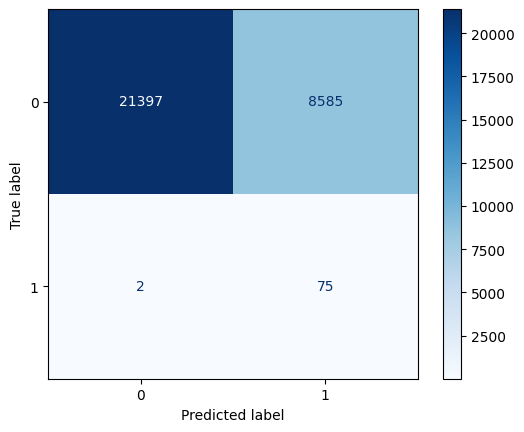

In [2]:
# 主程序
model = load_model()
_, test_dataloader = load_dataloader()
pred_labels, true_labels = predict(model, test_dataloader)
plot_confusion_matrix(pred_labels, true_labels)


In [3]:
# 可視化並保存圖像，使用預測標籤
save_dir = 'D:\Paper\Cardiac calcification\output_image\weight_15_pred'
visualize_and_save_images(test_dataloader, pred_labels, save_dir, label_type='pred')

AttributeError: 'DataLoader' object has no attribute 'images'

In [7]:
dataset = HeartCalcificationWithoutSplit('data/HeartCalcification/test', grid_size=45)


In [8]:
dataset

In [ ]:
for idx, (img, label) in enumerate(dataset):

    save_path = f'data/visual_45/output_image_{idx}.png'
    visualize_image(img, label, save_path=save_path)


In [6]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



class HeartCalcificationWithoutSplit(Dataset):
    def __init__(self, data_dir, grid_size=15):
        self.data_dir = data_dir
        self.grid_size = grid_size
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
        self.label_files = [f.replace('.png', '.txt') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        label_path = os.path.join(self.data_dir, self.label_files[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]

        with open(label_path, 'r') as f:
            line = f.readline().strip()
            if line:
                _, x_center, y_center, w, h = map(float, line.split())
                x = int(x_center * width)
                y = int(y_center * height)
            else:
                x, y = -1, -1

        num_blocks_h = height // self.grid_size
        num_blocks_w = width // self.grid_size
        label = np.zeros((num_blocks_h, num_blocks_w), dtype=np.int8)

        with open(label_path , 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line:
                    _, x_center, y_center, w, h = map(float, line.split())
                    x = int(x_center * width)
                    y = int(y_center * height)

                    block_i = y // self.grid_size
                    block_j = x // self.grid_size

                    if 0 <= block_i < num_blocks_h and 0 <= block_j < num_blocks_w:
                        label[block_i, block_j] = 1

        return img, label


